# Installing packages

In [ ]:
!pip install pydicom nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 103.0 MB/s eta 0:00:00


# Importing libraries

In [ ]:
import zipfile
import torch.nn.functional as F
import torch.nn as nn
import torch
import sys
import pydicom
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import importlib
import glob
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from pathlib import Path
from nilearn.image import resample_img
from matplotlib.colors import ListedColormap
from google.colab import drive

# Mounting Google Drive and loading libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import sys, importlib

# Add parent folder of the package
parent_dir = "/content/drive/MyDrive"
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now import your modules
from spine_score.src import extract, dataset, model

importlib.reload(extract)
importlib.reload(dataset)
importlib.reload(model)

from spine_score.src.model import print_metrics, evaluate_model, dice_coeff, DiceCELoss


Mounted at /content/drive


# Data Extraction

In [ ]:
# defaults to extracting from MyDrive
df = extract.extract_tsv_files()

Combined DataFrame shape: (25389, 79)


In [ ]:
# extract data from the zip files downloaded
# Update these paths to match your local environment if they changed
zip_path = "/content/drive/MyDrive/data/DukeCSpineSeg_"
interim_dir = Path("/content/drive/MyDrive/data/interim/")

extract.extract_data(zip_path, interim_dir)

Files in /content/drive/MyDrive/data/DukeCSpineSeg_segmentation.zip extracted.
Files in /content/drive/MyDrive/data/DukeCSpineSeg_imaging_files.zip extracted.
Files in /content/drive/MyDrive/data/DukeCSpineSeg_annotation.zip extracted.


In [ ]:
# Extract all .dcm files from their nested zips to help with data loading later
# root folder containing zip files
root_dir = "/content/drive/MyDrive/data/interim/imaging_files/case_image"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".zip"):
            zip_path = os.path.join(dirpath, file)
            # extract into the folder where the zip resides
            extract_to = dirpath
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Extracted {zip_path} to {extract_to}")

Extracted /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-000340/1.2.826.0.1.3680043.10.474.593973.6291/1.2.826.0.1.3680043.10.474.593973.6292.zip to /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-000340/1.2.826.0.1.3680043.10.474.593973.6291
Extracted /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-001134/1.2.826.0.1.3680043.10.474.593973.20991/1.2.826.0.1.3680043.10.474.593973.20992.zip to /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-001134/1.2.826.0.1.3680043.10.474.593973.20991
Extracted /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-001216/1.2.826.0.1.3680043.10.474.593973.22528/1.2.826.0.1.3680043.10.474.593973.22529.zip to /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-001216/1.2.826.0.1.3680043.10.474.593973.22528
Extracted /content/drive/MyDrive/data/interim/imaging_files/case_image/593973-000061/1.2.826.0.1.3680043.10.474.593973.1133/1.2.826.0.1.368004

Modality: MR
SeriesInstanceUID: 1.2.826.0.1.3680043.10.474.593973.3181
InstanceNumber: 6
ImagePositionPatient: [0.301974, -135.703, 134.583]
ImageOrientationPatient: [0.01386, 0.96547, 0.26014, -0.01497, 0.26034, -0.96540]
PixelSpacing: [0.4297, 0.4297]
SliceThickness: 3
SpacingBetweenSlices: 4
Manufacturer: GE MEDICAL SYSTEMS
SeriesDescription: sag t2


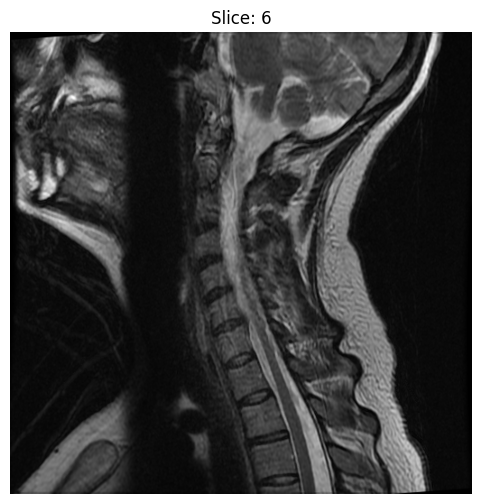

In [ ]:
# import pydicom
dcm_path = "/content/drive/MyDrive/data/interim/imaging_files/case_image/593973-000171/1.2.826.0.1.3680043.10.474.593973.3180/1.2.826.0.1.3680043.10.474.593973.3181/1.2.826.0.1.3680043.10.474.593973.3179.dcm"


# Load the DICOM
dcm = pydicom.dcmread(dcm_path)

fields = [
    "Modality",                 # Type of Scan (MR = Magnetic Resonance Imaging)
    "SeriesInstanceUID",        # ID unique to global files
    "InstanceNumber",           # slice index assigned by the scanner
    # This is the 3D coordinate of the top-left corner of the slice in the patient’s
    # reference system. (below)
    "ImagePositionPatient",
    "ImageOrientationPatient",  # Defines the 3D orientation vectors of the image axes
    "PixelSpacing",             # Real-world physical spacing (mm) between pixels in-plane (mm)
    "SliceThickness",           # Physical thickness (in mm) of each slice
    "SpacingBetweenSlices",     # The distance between slice centers
    "Manufacturer",             # The MRI scanner vendor
    "SeriesDescription",        # Human-readable name given by the technologist
]

for f in fields:
    value = getattr(dcm, f, "N/A")
    print(f"{f}: {value}")

# Extract pixel data (as numpy array)
img = dcm.pixel_array

# Display it
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title(f"Slice: {dcm.InstanceNumber}")
plt.axis("off")
plt.show()

Mask volume shape: (512, 512, 15)


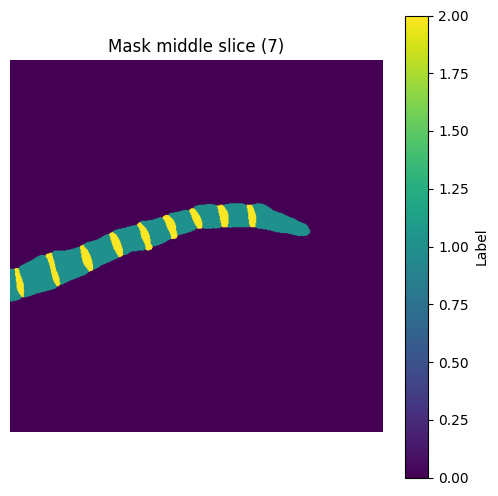

In [ ]:
# # Path to the mask file
mask_file = Path("/content/drive/MyDrive/data/interim/segmentation/593973-000171_Study-MR-174_Series-4_SEG.nii.gz")

# Load the NIfTI file
mask_nii = nib.load(mask_file)
mask_volume = mask_nii.get_fdata()  # shape: (H, W, D)
print("Mask volume shape:", mask_volume.shape)

# Show middle slice along depth
mid = mask_volume.shape[2] // 2

plt.figure(figsize=(6,6))
plt.imshow(mask_volume[:, :, mid], cmap="viridis")  # or use 'Reds', 'Blues', etc. for specific classes
plt.title(f"Mask middle slice ({mid})")
plt.axis("off")
plt.colorbar(label="Label")
plt.show()

# 3. Visualization

In [ ]:
# Define Visualization Function
def visualize_dicom_and_mask(dcm_path, mask_path, slice_index=None):
    # -------------------------------
    # 1. LOAD DICOM + PRINT METADATA
    # -------------------------------
    dcm = pydicom.dcmread(dcm_path)

    fields = [
        "Modality",
        "SeriesInstanceUID",
        "InstanceNumber",
        "ImagePositionPatient",
        "ImageOrientationPatient",
        "PixelSpacing",
        "SliceThickness",
        "SpacingBetweenSlices",
        "Manufacturer",
        "SeriesDescription",
    ]

    print("\n=== DICOM Metadata ===")
    for f in fields:
        value = getattr(dcm, f, "N/A")
        print(f"{f}: {value}")


    # -------------------------------
    # 2. DICOM IMAGE SLICE
    # -------------------------------
    img = dcm.pixel_array.astype(np.float32)

    # Normalize for display
    img_normalized = (img - img.min()) / (img.max() - img.min() + 1e-6)

    # -------------------------------
    # 3. LOAD MASK (NIfTI)
    # -------------------------------
    mask_nii = nib.load(mask_path)
    mask_volume = mask_nii.get_fdata()

    print("\nMask volume shape:", mask_volume.shape)

    # Determine slice: use provided or middle
    if slice_index is None:
        slice_index = mask_volume.shape[2] // 2

    if slice_index >= mask_volume.shape[2]:
        raise ValueError(f"Slice index {slice_index} exceeds mask depth {mask_volume.shape[2]}")

    mask_slice = mask_volume[:, :, slice_index]

    # -------------------------------
    # 4. VISUALIZE EVERYTHING
    # -------------------------------
    plt.figure(figsize=(18, 6))

    # --- DICOM slice ---
    plt.subplot(1, 3, 1)
    plt.imshow(img_normalized, cmap="gray")
    plt.title(f"DICOM Slice (Instance: {dcm.InstanceNumber})")
    plt.axis("off")

    # --- Mask slice ---
    plt.subplot(1, 3, 2)
    plt.imshow(mask_slice, cmap="viridis")
    plt.title(f"Mask Slice (Depth index: {slice_index})")
    plt.colorbar(label="Label")
    plt.axis("off")

    # --- Overlay ---
    plt.subplot(1, 3, 3)
    plt.imshow(img_normalized, cmap="gray")
    plt.imshow(mask_slice, cmap="jet", alpha=0.35)  # overlay
    plt.title("Overlay (Mask on DICOM)")
    plt.axis("off")

    plt.show()


=== DICOM Metadata ===
Modality: MR
SeriesInstanceUID: 1.2.826.0.1.3680043.10.474.593973.3
InstanceNumber: 8
ImagePositionPatient: [-7.44758, -135.757, -30.9355]
ImageOrientationPatient: [-0.00007, 0.90957, 0.41556, 0.04532, 0.41513, -0.90863]
PixelSpacing: [0.4297, 0.4297]
SliceThickness: 3
SpacingBetweenSlices: 4
Manufacturer: GE MEDICAL SYSTEMS
SeriesDescription: sag t2

Mask volume shape: (512, 512, 14)


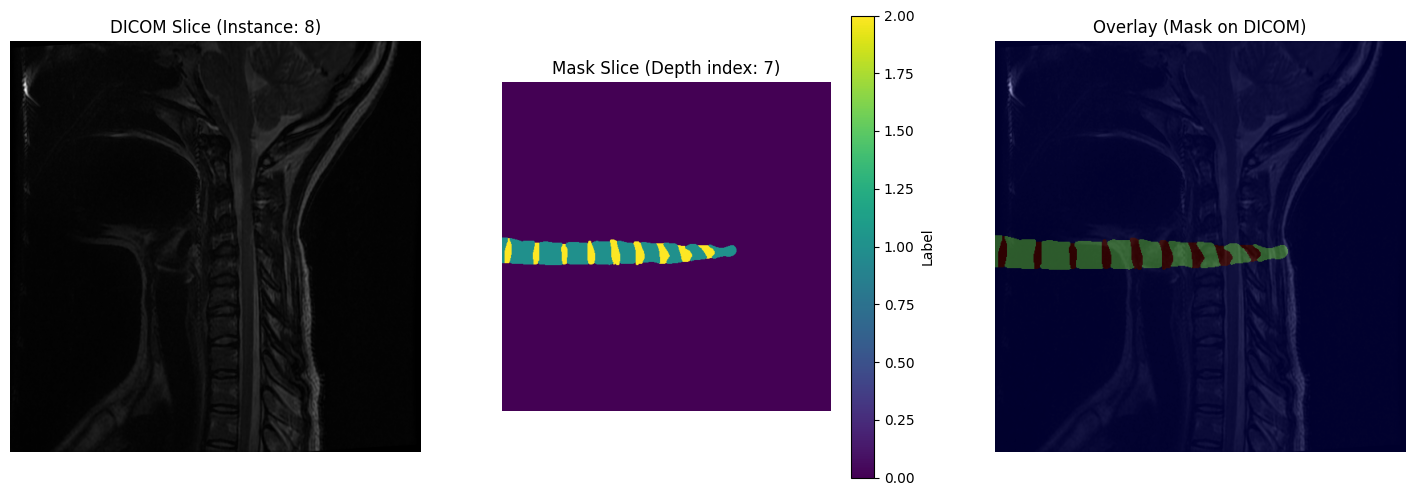

In [ ]:
# Set image and mask path
dcm_path = "/content/drive/MyDrive/data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.2/1.2.826.0.1.3680043.10.474.593973.3/1.2.826.0.1.3680043.10.474.593973.11.dcm"
mask_path = "/content/drive/MyDrive/data/interim/segmentation/593973-000001_Study-MR-1_Series-22_SEG.nii.gz"

# Call Visualization
visualize_dicom_and_mask(dcm_path, mask_path)


In [ ]:
def load_patient_volume(entry, slice_to_show=None, visualize=True):
    """
    Loads a patient's MRI volume and segmentation mask, aligns the mask,
    verifies matching slice count, and optionally displays overlay.
    """
    dicom_folder, mask_file = entry
    dicom_folder = Path(dicom_folder)

    # ----------------------------
    # Load DICOM slices
    # ----------------------------
    dcm_files = sorted(
          dicom_folder.glob("*.dcm"),
          key=lambda f: int(pydicom.dcmread(f).InstanceNumber)
    )
    slices = [pydicom.dcmread(f).pixel_array for f in dcm_files]
    img_volume = np.stack(slices, axis=-1)  # shape: (H, W, slices)

    # ----------------------------
    # Load mask
    # ----------------------------
    mask_nii = nib.load(mask_file)
    mask_volume = mask_nii.get_fdata()

    # ----------------------------
    # Verify matching slice count
    # ----------------------------
    if img_volume.shape[2] != mask_volume.shape[2]:
        print("❌ ERROR: Slice count mismatch!")
        print("DICOM slices:", img_volume.shape[2])
        print("Mask slices :", mask_volume.shape[2])
        print("Mask and DICOM DO NOT belong to same imaging series.")
        return img_volume, None

    # ----------------------------
    # Align mask (robust orientation fix)
    # ----------------------------
    # Fix common RSNA orientation mismatch
    mask_aligned = np.rot90(mask_volume, k=1, axes=(0,1))
    #mask_aligned = np.flip(mask_aligned, axis=0)

    # ----------------------------
    # Visualization
    # ----------------------------
    if visualize:
        mid = slice_to_show if slice_to_show is not None else img_volume.shape[2] // 2

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        plt.imshow(img_volume[:, :, mid], cmap="gray")
        plt.title("DICOM Slice")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(img_volume[:, :, mid], cmap="gray")
        plt.imshow(mask_aligned[:, :, mid], cmap="jet", alpha=0.4)
        plt.title("Overlay (Aligned Mask)")
        plt.axis("off")

        plt.show()

    return img_volume, mask_aligned

## Data Mapping (DICOM & Masks)

In [ ]:
# Matching Study Ids to ensure that segmentation and images are mapped appropriately
# DICOM root after extraction
dicom_root = "/content/drive/MyDrive/data/interim/imaging_files/case_image"

# Segmentation root
mask_root = "/content/drive/MyDrive/data/interim/segmentation"

# Map study_id -> DICOM folder
dicom_map = {}
for folder in glob.glob(os.path.join(dicom_root, "*")):  # first level
    study_id = os.path.basename(folder)
    # pick the deepest folder containing DICOMs
    dcm_subfolders = [f for f in glob.glob(os.path.join(folder, "**"), recursive=True) if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0]
    if dcm_subfolders:
        dicom_map[study_id] = dcm_subfolders[0]

# Map study_id -> mask file
mask_map = {}
for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
    study_id = os.path.basename(mask_file).split("_")[0]
    mask_map[study_id] = mask_file

# Only keep the studies that have both DICOMs and masks
dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

print(f"Found {len(dataset_entries)} paired DICOMs and masks")

Found 1231 paired DICOMs and masks


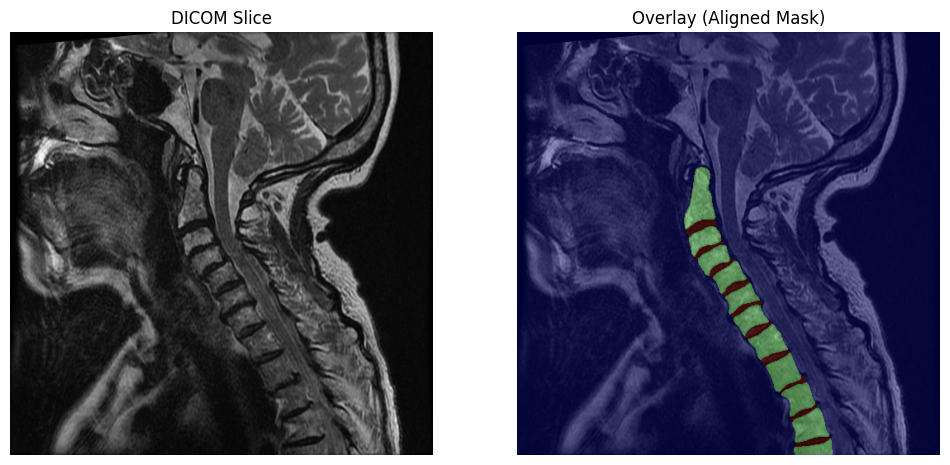

In [ ]:
img_vol, mask_vol = load_patient_volume(dataset_entries[0], visualize=True)

# Dataset Class for V-Net (3D volumes)

In [ ]:
# Define Spine data set class
class SpineDataset(Dataset):
    def __init__(self, entries, target_shape=(128,128,64)):
        self.entries = entries
        self.target_shape = target_shape  # (H, W, D)

    def __len__(self):
        return len(self.entries)

    def load_dicom_volume(self, folder):
        folder = Path(folder)

        files = sorted(
            folder.glob("*.dcm"),
            key=lambda f: int(pydicom.dcmread(f, stop_before_pixels=True).InstanceNumber)
        )

        volume = [pydicom.dcmread(f).pixel_array.astype(np.float32) for f in files]
        return np.stack(volume, axis=-1)   # (H, W, D)

    def load_mask_volume(self, mask_path):
        mask = nib.load(mask_path).get_fdata().astype(np.int16)
        return mask  # (H, W, D)

    def fix_depth_mismatch(self, img, mask):
        img_d = img.shape[-1]
        mask_d = mask.shape[-1]

        if img_d == mask_d:
            return mask

        print(f"[WARN] Depth mismatch: image={img_d}, mask={mask_d}")

        if mask_d > img_d:
            # Trim mask depth
            mask = mask[:, :, :img_d]
            print(f"[FIX] Trimmed mask to {mask.shape}")

        elif mask_d < img_d:
            # Pad mask depth
            pad_amount = img_d - mask_d
            mask = np.pad(mask, ((0,0),(0,0),(0,pad_amount)), mode="constant")
            print(f"[FIX] Padded mask to {mask.shape}")

        return mask

    def __getitem__(self, idx):
        dicom_folder, mask_file = self.entries[idx]

        img = self.load_dicom_volume(dicom_folder)
        mask = self.load_mask_volume(mask_file)

        # Fix mismatched depth
        mask = self.fix_depth_mismatch(img, mask)

        # Normalize MRI
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # Prepare tensors
        img_t = torch.tensor(img).unsqueeze(0).unsqueeze(0)
        mask_t = torch.tensor(mask).unsqueeze(0).unsqueeze(0)

        # Resize
        img_resized = F.interpolate(
            img_t, size=self.target_shape, mode="trilinear", align_corners=False
        )

        mask_resized = F.interpolate(
            mask_t.float(), size=self.target_shape, mode="nearest"
        )

        # Remove batch dimension
        img_resized = img_resized.squeeze(0)
        mask_resized = mask_resized.squeeze(0)

        return img_resized, mask_resized.squeeze(0).long()


# Build PyTorch Data Loader

In [ ]:
dataset = SpineDataset(dataset_entries, target_shape=(128,128,64))
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Build V-Net Model (PyTorch Implementation)

In [ ]:
class VNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)


class VNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.enc1 = VNetBlock(1, 16)
        self.down1 = nn.Conv3d(16, 32, 2, stride=2)

        self.enc2 = VNetBlock(32, 32)
        self.down2 = nn.Conv3d(32, 64, 2, stride=2)

        self.enc3 = VNetBlock(64, 64)

        self.up2 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec2 = VNetBlock(64, 32)

        self.up1 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec1 = VNetBlock(32, 16)

        self.out_conv = nn.Conv3d(16, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        d1 = self.down1(e1)

        e2 = self.enc2(d1)
        d2 = self.down2(e2)

        e3 = self.enc3(d2)

        u2 = self.up2(e3)
        u2 = torch.cat((u2, e2), dim=1)
        d2 = self.dec2(u2)

        u1 = self.up1(d2)
        u1 = torch.cat((u1, e1), dim=1)
        d1 = self.dec1(u1)

        return self.out_conv(d1)


# Loss Function (Dice + CE)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        pred_soft = torch.softmax(pred, dim=1)
        target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0,4,1,2,3).float()

        intersection = (pred_soft * target_onehot).sum(dim=(2,3,4))
        union = pred_soft.sum(dim=(2,3,4)) + target_onehot.sum(dim=(2,3,4))

        dice = 1 - (2 * intersection + 1e-8) / (union + 1e-8)
        return dice.mean()


criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Training Loop

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VNet(num_classes=3).to(device)

for epoch in range(10):
    model.train()
    total_loss = 0

    for img, mask in loader:
        img = img.to(device)            # (B,1,H,W,D)
        mask = mask.to(device)          # (B,H,W,D)

        pred = model(img)

        loss = criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss = {total_loss / len(loader):.4f}")


[WARN] Depth mismatch: image=15, mask=14
[FIX] Padded mask to (512, 512, 15)
[WARN] Depth mismatch: image=13, mask=19
[FIX] Trimmed mask to (320, 320, 13)
[WARN] Depth mismatch: image=14, mask=17
[FIX] Trimmed mask to (320, 320, 14)
[WARN] Depth mismatch: image=17, mask=15
[FIX] Padded mask to (640, 640, 17)


# Perform Model's Qualitative Analysis

In [ ]:
def compute_segmentation_metrics(preds, masks, num_classes=3):
    """
    Compute Accuracy, Precision, Recall, F1 per class.

    preds: torch.Tensor, shape [B,H,W,D], predicted class indices
    masks: torch.Tensor, shape [B,H,W,D], ground truth class indices
    """
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        mask_cls = (masks == cls)

        TP = (pred_cls & mask_cls).sum().item()
        FP = (pred_cls & (~mask_cls)).sum().item()
        FN = ((~pred_cls) & mask_cls).sum().item()
        TN = ((~pred_cls) & (~mask_cls)).sum().item()

        acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
        prec = TP / (TP + FP + 1e-6)
        rec = TP / (TP + FN + 1e-6)
        f1 = 2 * prec * rec / (prec + rec + 1e-6)

        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['f1'].append(f1)

    return metrics

def evaluate_model(model, dataloader, device, num_classes=3):
    """
    Evaluate a trained segmentation model on a dataset.

    Args:
        model: Trained PyTorch model
        dataloader: DataLoader for the dataset
        device: 'cuda' or 'cpu'
        num_classes: number of segmentation classes

    Returns:
        mean_dice: mean Dice coefficient over all samples
        class_dice: list of Dice per class
    """
    model.eval()
    all_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    all_dice = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)           # (B, C, H, W, D)
            masks  = masks.squeeze(1).to(device) # remove channel dim if needed: (B, H, W, D)

            outputs = model(images)              # (B, num_classes, H, W, D)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)  # (B, H, W, D)

            batch_dice = []
            for cls in range(num_classes):
                pred_cls = (preds == cls).float()
                mask_cls = (masks == cls).float()
                intersection = (pred_cls * mask_cls).sum()
                union = pred_cls.sum() + mask_cls.sum()
                dice = (2 * intersection + 1e-6) / (union + 1e-6)
                batch_dice.append(dice.item())
            all_dice.append(batch_dice)
            metrics = compute_segmentation_metrics(preds, masks, num_classes=3)
            for key in all_metrics:
                all_metrics[key].append(metrics[key])

    # Average over batches
    for key in all_metrics:
        all_metrics[key] = torch.tensor(all_metrics[key], dtype=torch.float32).mean(dim=0)

    all_dice = torch.tensor(all_dice)          # shape: (num_samples, num_classes)
    mean_dice = all_dice.mean().item()
    class_dice = all_dice.mean(dim=0).tolist() # Dice per class

    return mean_dice, class_dice, metrics

def print_metrics(metrics, class_names=None):
    """
    metrics: dict with keys 'accuracy', 'precision', 'recall', 'f1'
             each value is a list per class
    class_names: optional list of class names
    """
    import pandas as pd

    # If no class names were provided, number them
    num_classes = len(metrics["accuracy"])
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    df = pd.DataFrame({
        "Class": class_names,
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1"]
    })

    print("\n===== Evaluation Metrics per Class =====\n")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print("\n========================================\n")

In [ ]:
mean_dice, class_dice, metrics = evaluate_model(model, loader, device)
print_metrics(metrics)

In [ ]:
# Define function to perform model's qualitative analysis
def visualize_qualitative_results(dicom_folder, mask_path, model, device="cuda", num_slices=6):
    """
    Generate qualitative visualizations comparing:
      - Original MRI slice
      - Ground truth mask overlay
      - Predicted mask overlay

    Args:
        dicom_folder (str): path to DICOM folder
        mask_path (str): path to NIfTI segmentation (ground truth)
        model (torch.nn.Module): trained V-Net model
        device (str): 'cuda' or 'cpu'
        num_slices (int): number of slices to visualize across depth
    """

    # --------------------------
    # Load MRI + Ground Truth
    # --------------------------
    img_volume = dataset.load_dicom_volume(dicom_folder)
    mask_volume = nib.load(mask_path).get_fdata().astype(np.int16)

    # Normalize image for display
    img_norm = (img_volume - img_volume.min()) / (img_volume.max() - img_volume.min() + 1e-6)

    # Prepare tensor for model inference
    img_tensor = torch.tensor(img_norm).unsqueeze(0).unsqueeze(0).float().to(device)  # (1,1,H,W,D)

    # --------------------------
    # Run inference
    # --------------------------
    model.eval()
    with torch.no_grad():
        pred_logits = model(img_tensor)                # (1, C, H, W, D)
        pred_mask = torch.argmax(pred_logits, dim=1)   # (1, H, W, D)
        pred_mask = pred_mask.cpu().numpy()[0]         # (H, W, D)

    # --------------------------
    # Pick slices evenly across volume
    # --------------------------
    depth = img_volume.shape[-1]
    selected_slices = np.linspace(0, depth - 1, num_slices, dtype=int)

    # --------------------------
    # Plot Qualitative Comparison
    # --------------------------
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 3 * num_slices))

    for i, z in enumerate(selected_slices):
        # MRI slice
        axes[i, 0].imshow(img_norm[:, :, z], cmap="gray")
        axes[i, 0].set_title(f"MRI Slice {z}")
        axes[i, 0].axis("off")

        # Ground Truth overlay
        axes[i, 1].imshow(img_norm[:, :, z], cmap="gray")
        axes[i, 1].imshow(mask_volume[:, :, z], cmap="viridis", alpha=0.35)
        axes[i, 1].set_title(f"Ground Truth Mask (Slice {z})")
        axes[i, 1].axis("off")

        # Predicted Mask overlay
        axes[i, 2].imshow(img_norm[:, :, z], cmap="gray")
        axes[i, 2].imshow(pred_mask[:, :, z], cmap="jet", alpha=0.35)
        axes[i, 2].set_title(f"Predicted Mask (Slice {z})")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
dicom_folder = dataset_entries[0][0]
mask_path = dataset_entries[0][1]

visualize_qualitative_results(
    dicom_folder=dicom_folder,
    mask_path=mask_path,
    model=model,     # your trained V-Net
    device=device,
    num_slices=6     # show 6 evenly spaced slices
)